# Lending Club Case Study

## A. Introduction

### Business Use Case

Lending Club Inc., as the largest online loan marketplace, offers a variety of loans including personal, business, and medical procedure financing through an efficient online platform. A major challenge they face, common in the lending industry, is credit loss, which occurs when borrowers default on their loans. These defaulters, referred to as 'charged-off' customers, represent the largest source of financial loss. To mitigate this, the company aims to identify these high-risk applicants. The objective is to understand the key factors that indicate the likelihood of a loan default, allowing the company to refine its loan portfolio and enhance its risk assessment strategies.

### Problem Statement

The aim of this analysis is to use Exploratory Data Analysis to understand the key driving factors which indicate whether a customer is likely to default on a loan. To achieve this, we will make use of various data cleaning, exploration as well as visualization techniques using Python.

## B. Data Import and Preliminary Investigations

In this step, we will import the data as well as some required Python packages and perform some preliminary investigations with the intent of identifying data cleaning and feature engineering opportunities and a general direction of analysis.

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

df = pd.read_csv('loan.csv')
df.head()

/var/folders/_n/smmmfvbj4cl91v_6q83cw9b00000gn/T/ipykernel_22435/923562842.py:6: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('loan.csv')


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


Let us first start by identifying the percentage of nulls for each column.

In [2]:
((df.isnull().sum() / df.shape[0]) * 100).round(2).value_counts()

100.00    54
0.00      43
0.14       2
6.19       1
2.71       1
32.58      1
0.03       1
64.66      1
92.99      1
0.13       1
0.18       1
97.13      1
0.01       1
1.75       1
0.10       1
dtype: int64

We can see that there are 54 columns with 100% of null values, or 54 completely empty columns. We can drop these. Next, there are 43 columns which are completely non-null. So a roughly 50-50 distribution between usable and unusable columns. There are 2 columns with over 90% nulls, 1 column with 65% nulls and 1 column with 33% nulls, which we can investigate further. The other columns containing null values are extremely low in number so we can either impute or discard the null rows for these.

Let us start by removing the unusable columns.

#### Null Treatment

In [3]:
nulls = (df.isnull().sum() / df.shape[0])
df = df[nulls[nulls < 1].index]
((df.isnull().sum() / df.shape[0]) * 100).round(2).value_counts()

0.00     43
0.14      2
6.19      1
2.71      1
32.58     1
0.03      1
64.66     1
92.99     1
0.13      1
0.18      1
97.13     1
0.01      1
1.75      1
0.10      1
dtype: int64

Now that we have removed the empty columns, let us investigate the columns with over 90% nulls.

In [4]:
def null_columns(df, percentage):
    '''
    Returns the columns which have greater than the provided percentage of nulls.
    '''
    nulls = (df.isnull().sum() / df.shape[0])
    return nulls[nulls > percentage].index

null_columns(df, 0.9)

Index(['mths_since_last_record', 'next_pymnt_d'], dtype='object')

As per the data dictionary, `mths_since_last_record` indicates the number of months since any publicly recorded incident that is indicative of a borrower's credit risk, such as a bankruptcy filing, tax lien, court judgment, or any other legal mark. `next_pymnt_d` refers to the next payment due date for the borrower.

We can create a feature called `risk_incident` that characterizes whether or not the borrower has had any credit risk related incident (described above). Another feature called `loan_paid_off` which indicates whether or not the loan has been paid off by the borrower.

Thus we can remove both the `mths_since_last_record` and `next_pymnt_d` columns, despite having characterized them to some extent. Both of the new features are potentially good indicators of a borrower's credit risk.

In [5]:
df['risk_incident'] = np.where(df['mths_since_last_record'].isnull(), 0, 1)
df['loan_paid_off'] = np.where(df['next_pymnt_d'].isnull(), 1, 0)
df.drop(['mths_since_last_record', 'next_pymnt_d'], axis = 1, inplace = True)
((df.isnull().sum() / df.shape[0]) * 100).round(2).value_counts()

0.00     45
0.14      2
6.19      1
2.71      1
32.58     1
0.03      1
64.66     1
0.13      1
0.18      1
0.01      1
1.75      1
0.10      1
dtype: int64

In [6]:
null_columns(df, 0.3)

Index(['desc', 'mths_since_last_delinq'], dtype='object')

As per the data dictionary, `desc` indicates the description of loan provided by the borrower, in other words, the purpose of the loan. This is not likely to provide any significant insight on the credit risk profile of a borrower. Hence we can drop this column.

`mths_since_last_delinq` indicates the number of months since the last delinquency of a borrower. This is a potential indicator of the credit risk profile, however, as above, it is better to derive a binary feature out of it indicating whether or not a borrower has had a delinquency in their credit history. After this, we can drop this column too.

In [7]:
df['any_past_delinquency'] = np.where(df['mths_since_last_delinq'].isnull(), 0, 1)
df.drop(['desc', 'mths_since_last_delinq'], axis = 1, inplace = True)
((df.isnull().sum() / df.shape[0]) * 100).round(2).value_counts()

0.00    46
0.14     2
6.19     1
2.71     1
0.03     1
0.13     1
0.18     1
0.01     1
1.75     1
0.10     1
dtype: int64

Next, we will look at columns with 5 % or less number of nulls, and treat them accordingly.

In [8]:
null_columns(df, 0)

Index(['emp_title', 'emp_length', 'title', 'revol_util', 'last_pymnt_d',
       'last_credit_pull_d', 'collections_12_mths_ex_med',
       'chargeoff_within_12_mths', 'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

In [9]:
df = df.loc[~df['emp_length'].isnull(), ]
((df.isnull().sum() / df.shape[0]) * 100).round(2).value_counts()

0.00    47
0.14     2
3.73     1
0.03     1
0.12     1
0.17     1
0.01     1
1.80     1
0.10     1
dtype: int64

In [10]:
null_columns(df, 0.01)

Index(['emp_title', 'pub_rec_bankruptcies'], dtype='object')

<Axes: >

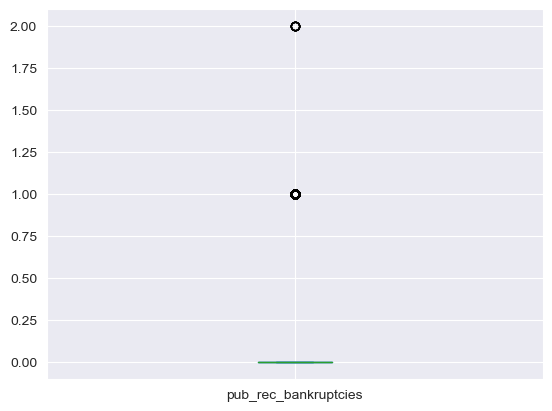

In [11]:
df['pub_rec_bankruptcies'].plot(kind = 'box')

We can see that `pub_rec_bankruptcies` is majorly concentrated around 0, and this being an important indicator for a borrower's credit risk, we can safely impute the missing values as 0. Another reason for imputing with 0 is that if the number of publicly recorded bankruptcies is unknown, then it is safer to assume non-bankruptcy than any other value because otherwise a false negative may result in loss of business for the lending club.

In [12]:
df['pub_rec_bankruptcies'].fillna(0, inplace = True)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].astype(int)

((df.isnull().sum() / df.shape[0]) * 100).round(2).value_counts()

0.00    48
0.14     2
3.73     1
0.03     1
0.12     1
0.17     1
0.01     1
0.10     1
dtype: int64

Now that we have treated all columns with more than 1% null values, we can safely remove the null rows for the remaining columns, which anyway have less than 1% nulls.

In [13]:
for col in null_columns(df, 0):
    df = df.loc[~df[col].isnull(), ]

((df.isnull().sum() / df.shape[0]) * 100).round(2).value_counts()

0.0    56
dtype: int64

## C. Exploratory Data Analysis

#### Data Treatment

In this section, we shall explore the variables themselves and inter-variable correlation and try to find key indicators of credit risk for a borrower.

We start with seggregating categorical and continuous variables. The variables are currently of `object` and `numeric` types.

Since we have a total of 56 non-null variables, we also need to find a way, if possible, to reduce the number of variables to analyse in order to optimise efforts. This includes reducing pairs of highly correlated variables into single variables either by dropping one variable from the pair or deriving a combined metric out of the two and dropping both.

Among the `numeric` data types, we will find both categorical and continuous variables. If we are able to seggregate only the continuous numeric variables, then we will be able to easily use seaborn to find highly correlated pairs. For this, we will start with a distribution of the number of unique values in a variable.

But before doing so, we need to drop any `id` columns in the data that do not contribute anything to the analysis and would instead complicate things.

In [14]:
id_cols = [col for col in df.columns if col.endswith('id')]
df.drop(id_cols, axis = 1, inplace = True)

In [15]:
num_unique = pd.Series([df[col].nunique() for col in df.select_dtypes('number').columns])
num_unique.describe()

count       32.000000
mean      6461.718750
std      11585.243782
min          1.000000
25%          2.000000
50%        951.500000
75%       5579.750000
max      35407.000000
dtype: float64

This clearly shows that the bottom 25% of this distribution are mostly numeric categorical variables since the 25th percentile is 2.25, or 25% of the variables have 2-3 unique values. The median is 1047, which means at the 50% mark, we are likely getting some continuous variables too. Let us visualize this further.

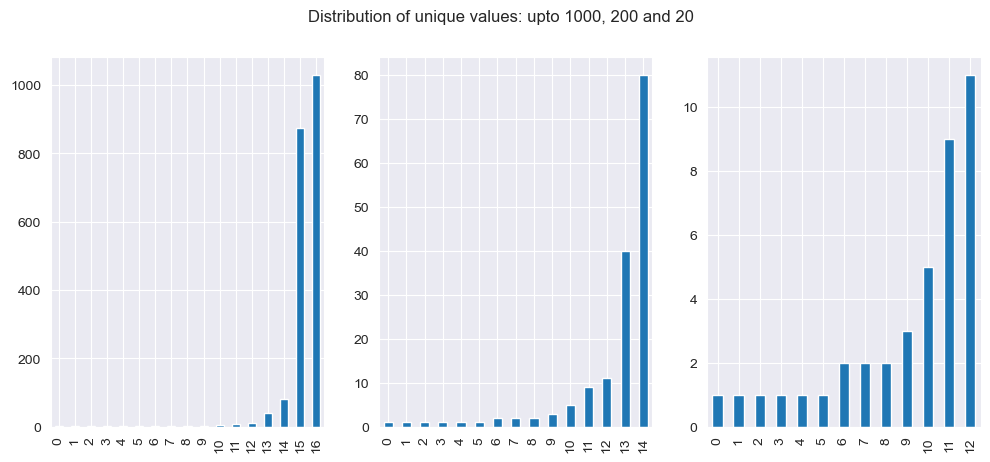

In [16]:
fig, ax = plt.subplots(1, 3);
fig.suptitle('Distribution of unique values: upto 1000, 200 and 20');
fig.set_figwidth(12);

num_unique[num_unique < 1047].sort_values().reset_index(drop = True).plot(kind = 'bar', ax = ax[0]);
num_unique[num_unique < 200].sort_values().reset_index(drop = True).plot(kind = 'bar', ax = ax[1]);
num_unique[num_unique < 20].sort_values().reset_index(drop = True).plot(kind = 'bar', ax = ax[2]);

From the second plot, we see that the number of unique values in a variable rises sharply after 20. So any variable with less than 20 unique values, or 0.05% of the total number of records, can be safely assumed to be numerical and categorical.

In [17]:
numeric_categorical = [col for col in df.select_dtypes('number').columns if df[col].nunique() < 20]
len(numeric_categorical)

13

We have 13 numeric categorical columns. So remaining numeric columns can be assumed to be continuous.

In [18]:
numeric_continuous = [col for col in df.select_dtypes('number').columns if df[col].nunique() >= 20]
len(numeric_continuous)

19

Let us now examine the columns of type `object`.

In [19]:
df.select_dtypes('object').columns

Index(['term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'revol_util', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type'],
      dtype='object')

The following treatments are applied.

- `term`: number of months, treated and converted to integer
- `int_rate`: converted to float
- `sub_grade`: converted to int
- `issue_d`: converted to datetime
- `pymnt_plan`: only one value, dropped
- `url`: non-contributor, dropped
- `title`: non-contributor, dropped
- `zip_code`: non-contributor, dropped
- `earliest_cr_line`: converted to datetime
- `revol_util`: converted to float
- `initial_list_status`: only one value, dropped
- `last_pymnt_d`: converted to datetime
- `application_type`: only one value, dropped

In [20]:
## Treatment
df['term'] = df['term'].str.strip().str.strip(' months').astype(int)
df['int_rate'] = df['int_rate'].str.strip('%').astype(float)
df['sub_grade'] = df['sub_grade'].str.slice(1,).astype(int)
df['issue_d'] = pd.to_datetime(df['issue_d'], format = '%b-%y').dt.date
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format = '%b-%y').dt.date
df['revol_util'] = df['revol_util'].str.strip('%').astype(float)
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format = '%b-%y').dt.date
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format = '%b-%y').dt.date

## Adding to numerical variable categories
numeric_categorical.extend(['term', 'sub_grade'])
numeric_continuous.extend(['int_rate', 'revol_util', ])

## Dropping unnecessary variables
df.drop(['emp_title', 'pymnt_plan', 'url', 'title', 'zip_code',
         'initial_list_status', 'application_type'
         ], axis = 1, inplace = True)

## Renaming date columns to standard form
df.rename(columns = {'earliest_cr_line': 'earliest_cr_line_d'}, inplace = True)

Next, we look at those columns which have only 1 unique value, since they do not contribute to the analysis in any way. We shall remove these.

In [21]:
single_val_cols = [col for col in df.columns if df[col].nunique() == 1]
df.drop(single_val_cols, axis = 1, inplace = True)
df.shape

(37040, 41)

We can also calculate the percentage of open credit lines which would give an indication of how dependent the borrower is on credit.

In [22]:
## Percentage of open credit lines
df['open_acc_perc'] = df['open_acc'] / df['total_acc']
df.drop(['open_acc', 'total_acc'], axis = 1, inplace = True)

Let us now look at correlated features within continuous variables to identify possible proxies.

In [23]:
numeric_continuous = list(set(numeric_continuous).intersection(df.columns)) + ['open_acc_perc']

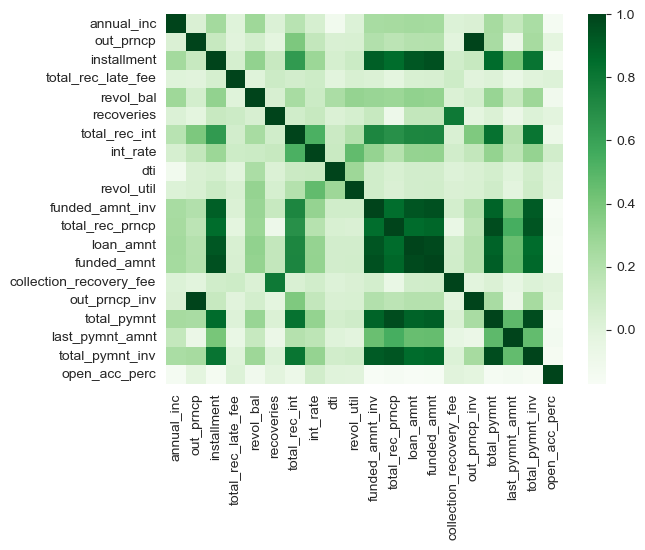

In [24]:
sns.heatmap(df[numeric_continuous].corr(), cmap = 'Greens');

We immediately see some very obvious patterns. `loan_amnt`, `funded_amnt`, `funded_amnt_inv` and `installment` are a very tightly correlated group that all quantify one thing i.e. the amount of money loaned to the borrower. We can keep `funded_amnt` and drop the rest.

Similarly, `total_pymnt`, `total_pymnt_inv`, `total_rec_prncp` are related to recovery. These are highly correlated with `total_rec_int`, but the total received interest is a different quantity than the recovered amount. So we keep that and drop 2 out of the 3 amount recovery metrics.

We see high correlation between loan amount metrics and recovery amount metrics, but that is self explanatory.

An interesting correlation we find here is the high correlation between `recoveries`, which is the gross recovery amount post charge-off and `collection_recovery_fee`, which is expenses occurred by lender for recovery. The correlation is evident, because a higher recovery amount should require more effort from the lender and hence more fees, but we can compute a `net_recovery_amnt_pco` from these two which is the amount recovered post charge-off and fee deduction.

In [25]:
df['net_recovery_amnt_pco'] = df['recoveries'] - df['collection_recovery_fee']

df.drop(['loan_amnt', 'funded_amnt_inv', 'installment', 'total_pymnt_inv',
         'total_pymnt', 'recoveries', 'collection_recovery_fee'],
        axis = 1,
        inplace = True)

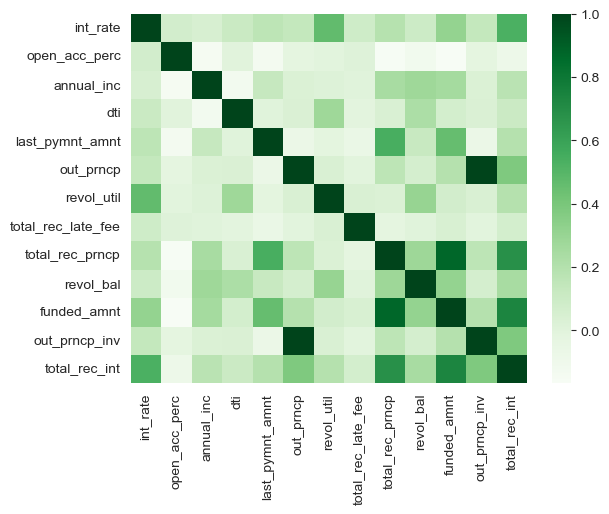

In [26]:
numeric_continuous = list(set(numeric_continuous).difference(['loan_amnt', 'funded_amnt_inv', 'installment',
                                                        'total_pymnt_inv','total_pymnt', 'recoveries',
                                                        'collection_recovery_fee']))
sns.heatmap(df[numeric_continuous].corr(), cmap = 'Greens');

`out_prncp` and `out_prncp_inv` are two other variables of which only one is useful.

In [27]:
numeric_continuous.remove('out_prncp_inv')

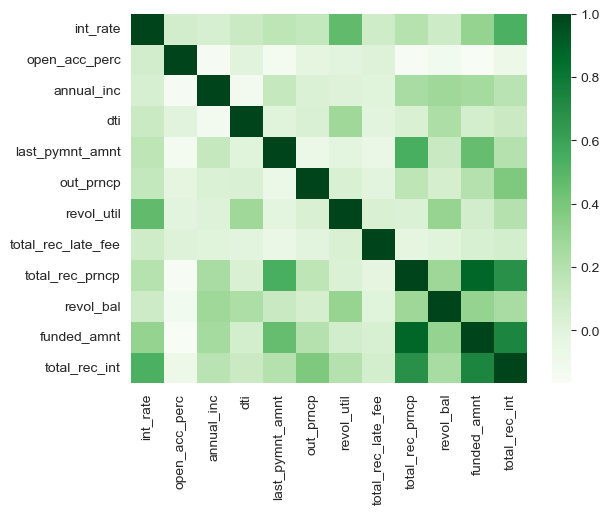

In [28]:
df.drop('out_prncp_inv', axis = 1, inplace = True)
sns.heatmap(df[numeric_continuous].corr(), cmap = 'Greens');

In [29]:
categorical_cols = numeric_categorical +\
 [col for col in df.select_dtypes('object').columns if not col.endswith('_d')]

Whether or not a loan is a bad loan or not is determined by the total principal recovered from the borrower. If the total recovered principal is less tha the funded amount, then it is a bad loan. However, let us first look for incorrect data rows where total recovered principal may be more than funded amount for whatever reason.

In [30]:
df.loc[df['total_rec_prncp'] > df['funded_amnt'], ].shape[0]

112

These are incorrect data and need to be removed from the dataaset if we are to correctly analyze the key drivers of a bad loan.

In [31]:
df = df.loc[df['total_rec_prncp'] <= df['funded_amnt'], ]
df.shape

(36928, 33)

Finally, let us see whether the `loan_status` column corresponds correctly with the `loan_paid_off` column.

In [32]:
pd.crosstab(index = df['loan_status'], columns = df['loan_paid_off'])

loan_paid_off,0,1
loan_status,,
Charged Off,0,5049
Current,1066,0
Fully Paid,0,30813


Clearly `loan_status` is "Fully Paid" for those with `loan_paid_off` = 1, hence we can now drop the `loan_paid_off` column.

In [33]:
df.drop('loan_paid_off', axis = 1, inplace = True)
df.shape

(36928, 32)

#### Distribution Analysis - Continuous Variables

Since a charged-off loan indicates a defaulting behaviour, we shall now analyse the probability of a loan being charged off (or defaulted) for various features.

In [34]:
categorical_cols = list(set(categorical_cols).intersection(df.columns))
numeric_continuous = list(set(numeric_continuous).intersection(df.columns))

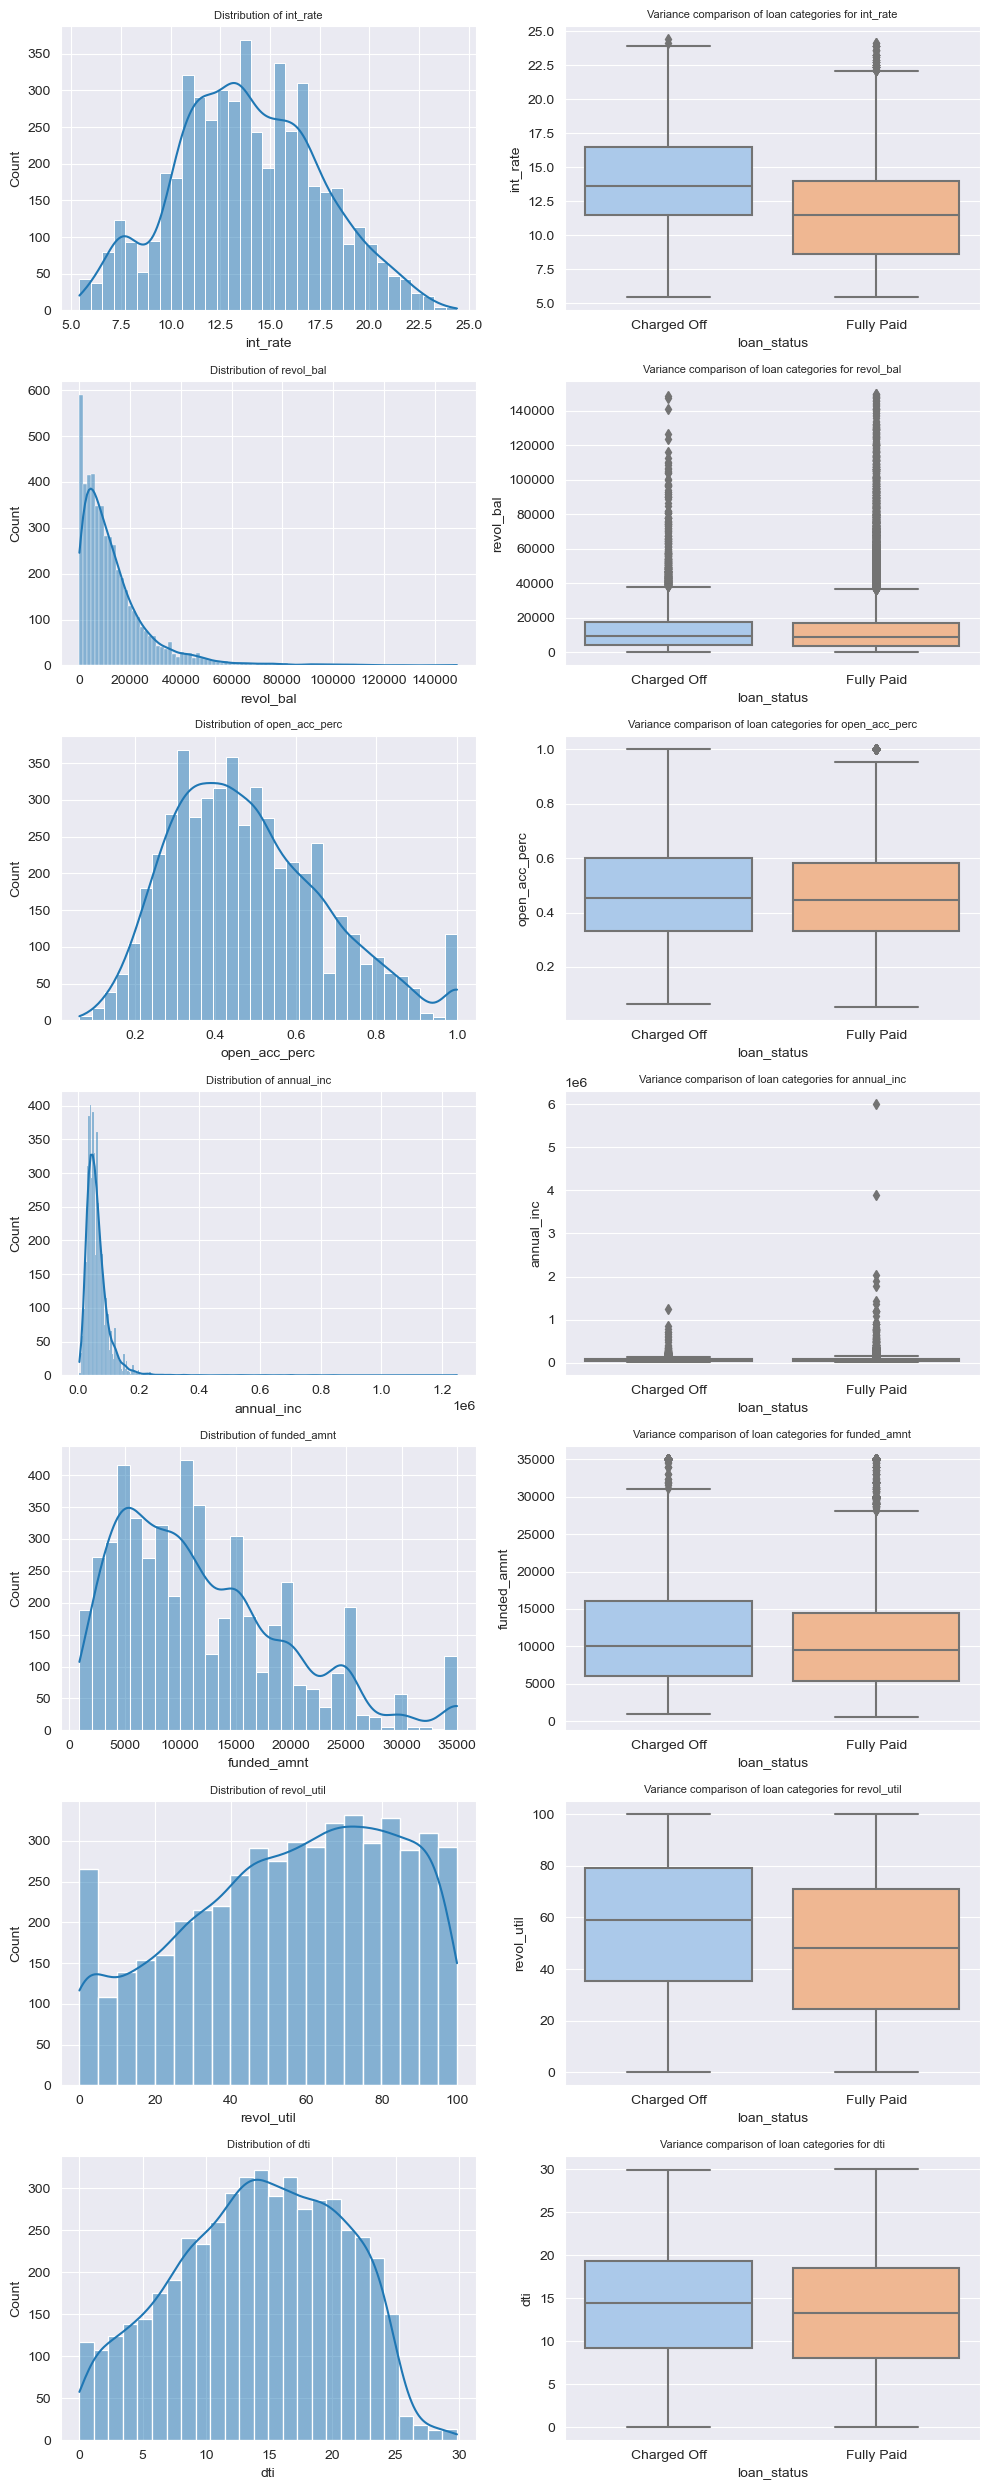

In [35]:
df2 = df.loc[df['loan_status'] != 'Current', ]

analysis_cols = ['int_rate', 'revol_bal', 'open_acc_perc', 'annual_inc',
                 'funded_amnt', 'revol_util', 'dti']

fig, ax = plt.subplots(len(analysis_cols), 2);
fig.set_layout_engine('tight');
fig.set_figheight(25);
fig.set_figwidth(10);
for i, col in enumerate(analysis_cols):
    sns.histplot(data = df.loc[df['loan_status'] == 'Charged Off', col],
                 kde = True, ax = ax[i][0]);
    ax[i][0].set_title(f'Distribution of {col}', fontsize = 8);
    sns.boxplot(data = df2, x = 'loan_status', y = col,
                ax = ax[i][1], palette = 'pastel');
    ax[i][1].set_title(f'Variance comparison of loan categories for {col}',
                       fontsize = 8);

We can see from this analysis that `loan_status` is significantly dependent on variation in `int_rate`, `funded_amnt` and `revol_util`. We will take a deeper look at `anual_inc` by removing the outliers.

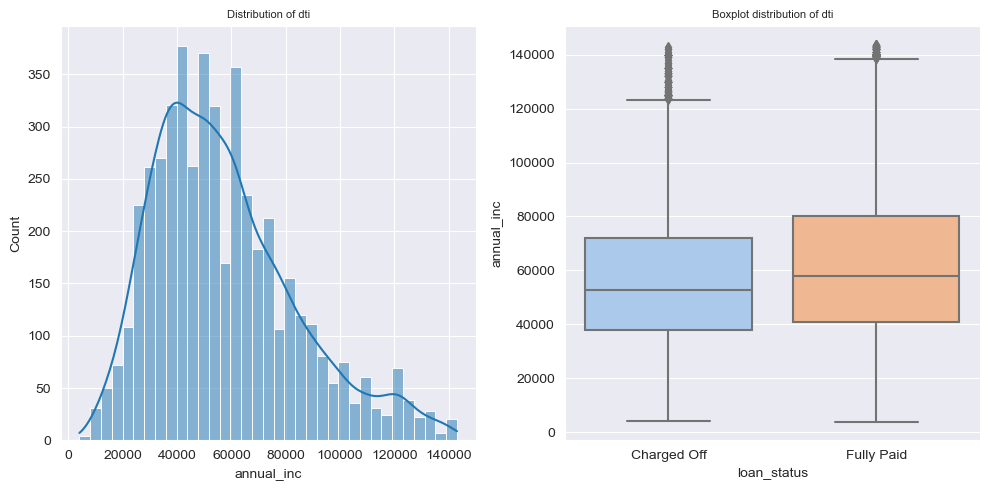

In [36]:
annual_inc_q1 = df2['annual_inc'].quantile(0.25)
annual_inc_q3 = df2['annual_inc'].quantile(0.75)
iqr = annual_inc_q3 - annual_inc_q1

df3 = df2.loc[(df2.annual_inc <= annual_inc_q3 + (1.5 * iqr)) &\
              (df2.annual_inc >= annual_inc_q1 - (1.5 * iqr)), ]

fig, ax = plt.subplots(1, 2);
fig.set_layout_engine('tight');
fig.set_figheight(5);
fig.set_figwidth(10);

sns.histplot(data = df3.loc[df['loan_status'] == 'Charged Off', 'annual_inc'],
             kde = True, ax = ax[0]);
ax[0].set_title(f'Distribution of {col}', fontsize = 8);
sns.boxplot(data = df3, x = 'loan_status', y = 'annual_inc',
            ax = ax[1], palette = 'pastel');
ax[1].set_title(f'Boxplot distribution of {col}', fontsize = 8);

As suspected, variation in `loan_status` is also dependent on `annual_inc`.

Hence, among continuous variables, we have determined that the biggest possible indicators of a defaulter are:
- `int_rate`
- `annnual_inc`
- `revol_util`
- `funded_amnt`

The other variables, i.e. `open_acc_perc`, `revol_bal` and `dti`, though showing significant variation for charged-off loans, show similar variation for fully paid loans. Hence, we can consider these as characteristic variations for all borrowers and not something that can significantly differentiate between a defaulter and a non-defaulter.

#### Distribution Analysis - Categorical Variables

Next, we do a similar analysis for the categorical variables. However, since these are categorical variables, we can take the percentage of total loans which are charged off rather than the absolute number of charged off loans as our metric. The proportion will be a better indicator, because if it shows significant variation across different classes of a categorical feature, it can be assumed as a key contributor.

Additionally, `emp_length` is an ordinal variable but it is coded in a way which is difficult for Python to automatically order, hence we are creating a new variable `emp_length_code` which captures that order.

In [37]:
categorical_cols.remove('loan_status')
categorical_cols.remove('emp_length')

df['emp_length_code'] = df['emp_length'].apply(lambda x: 0 if x == '< 1 year' else int(x[:2].strip()))
categorical_cols.append('emp_length_code')

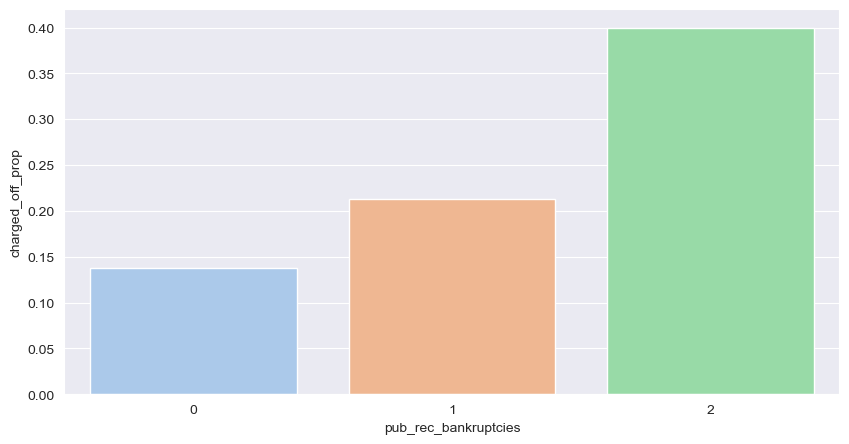

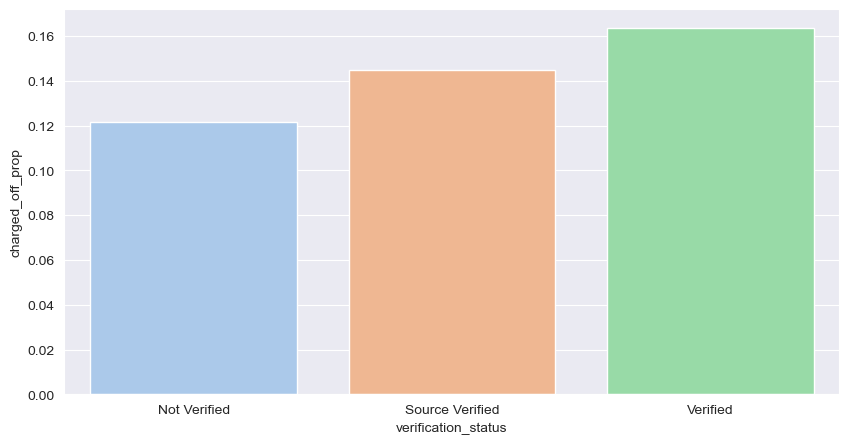

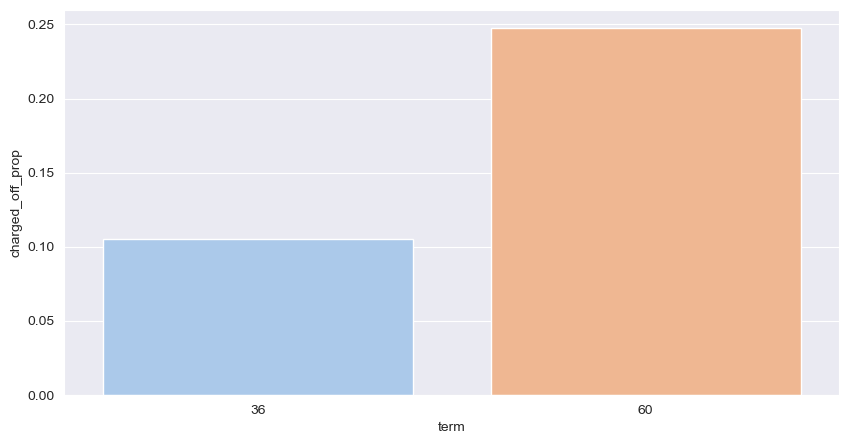

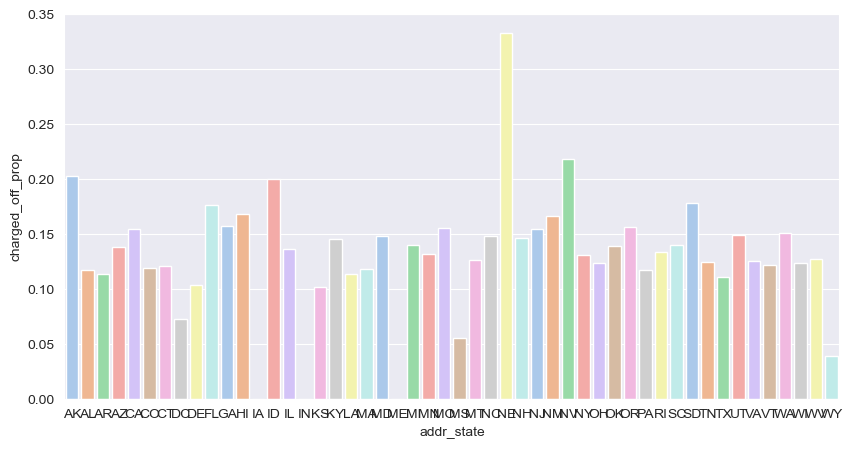

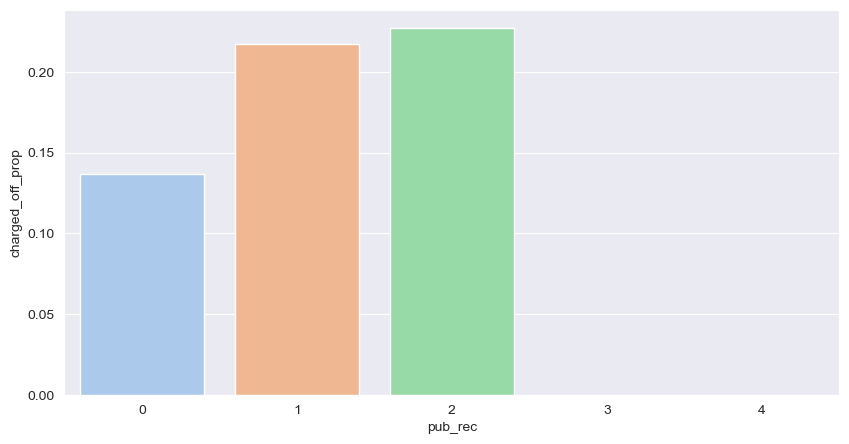

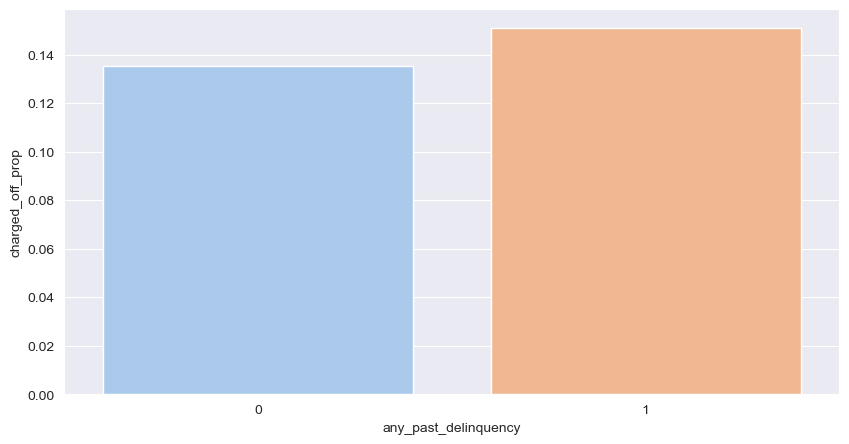

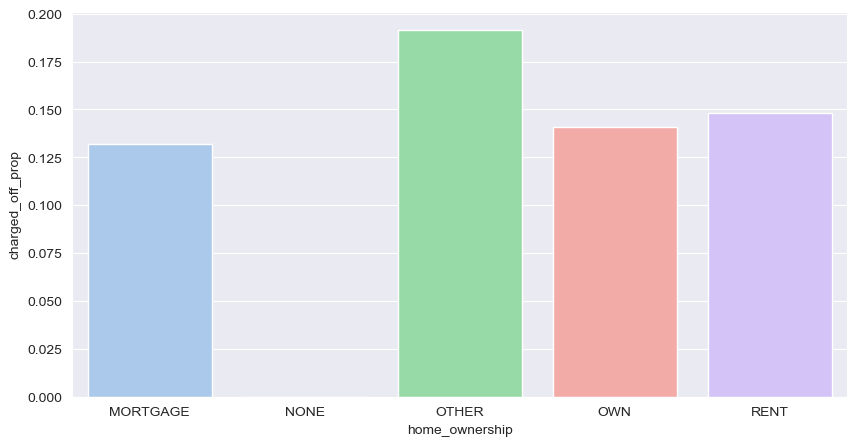

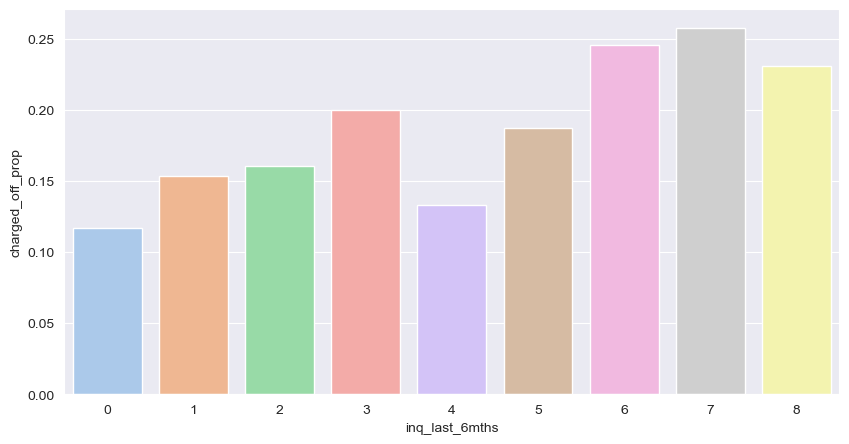

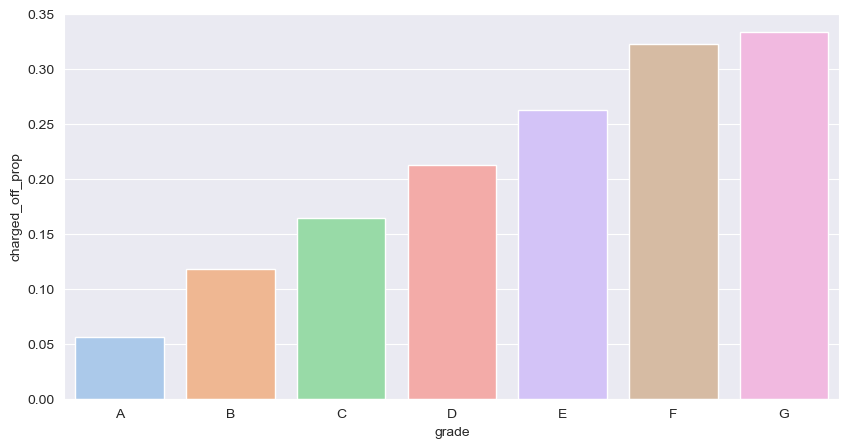

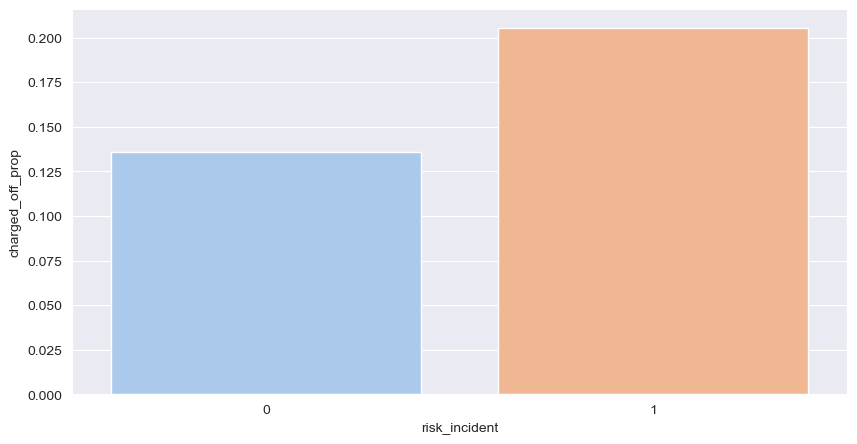

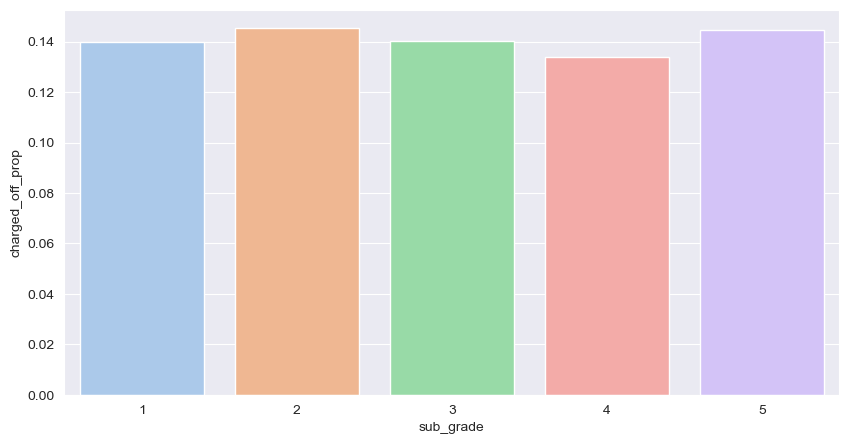

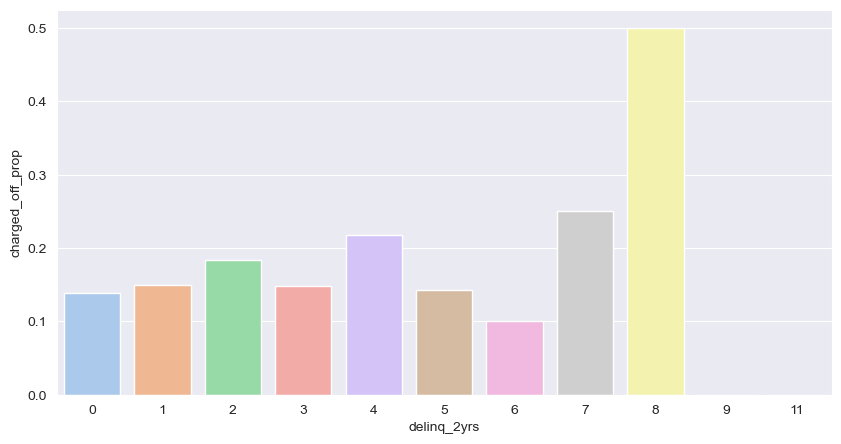

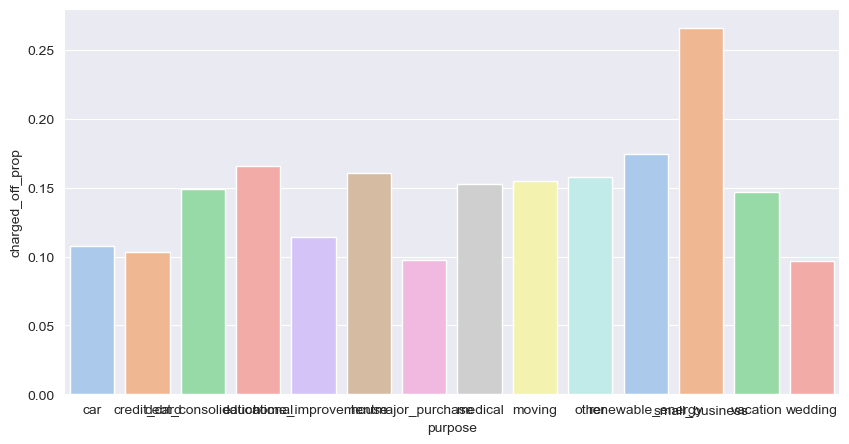

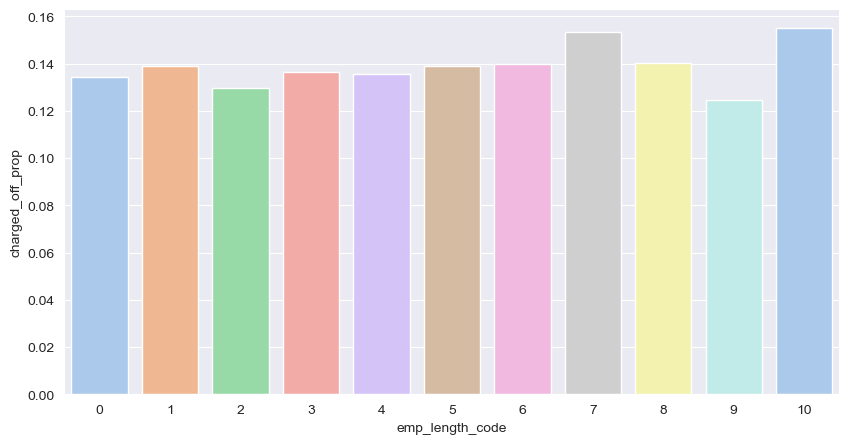

In [38]:

for col in categorical_cols:

    plt.figure(figsize = [10, 5]);
    temp = pd.crosstab(df[col], df['loan_status']).reset_index()
    temp['Total Non Current Loans'] = temp['Charged Off'] + temp['Fully Paid']
    temp['charged_off_prop'] = temp['Charged Off'] / temp['Total Non Current Loans']
    sns.barplot(data = temp, x = col, y = 'charged_off_prop', palette = 'pastel');

From the above charts, it is obvious that among the categorical features, `term` is the most prominent indicator of a potential defaulter. Other prominent indicators are `grade`, `risk_incident` and `pub_rec_bankruptcies`.

Although `verification_status` shows a very prominent correlation with loan status, we cannot use it as an indicator because loans are more likely to be given out to verified sources so we will obviously have more charge-offs for higher verification levels.

## D. Conclusion

The following are the list of prominent indicators of a loan defaulter as obtained from the above analysis.

- `int_rate` -> interest rate
- `annnual_inc` -> annual income
- `revol_util` -> amount of revolving credit
- `funded_amnt` -> loan amount funded
- `term` -> term of loan
- `grade` -> loan grade (higher grade points to higher risk of default)
- `risk_incident` -> derived metric indicating whether the borrower has had any publicly recorded credit risk incident in the past, based on `mths_since_last_record`
- `pub_rec_bankruptcies` -> number of publicly recorded bankruptcies